# <span style="color:#0b486b">  FIT3181/5215: Deep Learning (2025)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Clayton):* **A/Prof Zongyuan Ge** | zongyuan.ge@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Arghya Pal** | arghya.pal@monash.edu <br/>
 <br/>
*Head Tutor 3181:*  **Ms Ruda Nie H** |  \[RudaNie.H@monash.edu \] <br/>
*Head Tutor 5215:*  **Ms Leila Mahmoodi** |  \[leila.mahmoodi@monash.edu \]

<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***

# Tutorial 9a: Neural machine translation with Transformer

This tutorial demonstrates how to create and train a sequence-to-sequence Transformer model for machine translation. It was adapted from the Tensorflow's tutorial ["Neural machine translation with a Transformer and Keras"](https://www.tensorflow.org/text/tutorials/transformer) and is licensed under the [Apache License version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

**The main contents of this tutorial are**:

- Review the Transformer.
- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.

## A brief introduction of Transformer

The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017). Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences. As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

Advantages of Transformers include:

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

The above figure shows the encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads) (Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)).

### Attention refresher

Attention layers are used throughout the Transformer model. These are all identical except for how the attention is configured. Before getting into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

## Data Pre-processing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import nltk
import numpy as np
import re
import shutil
import os
import unicodedata
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!gdown https://drive.google.com/uc?id=1J6ldngMZ-84Et5IPHG8S-mYE2BBJMz48

Downloading...
From (original): https://drive.google.com/uc?id=1J6ldngMZ-84Et5IPHG8S-mYE2BBJMz48
From (redirected): https://drive.google.com/uc?id=1J6ldngMZ-84Et5IPHG8S-mYE2BBJMz48&confirm=t&uuid=81c51b91-5e99-465e-9ad3-8a89722068fc
To: /content/Tut11_data.zip
100% 223M/223M [00:07<00:00, 30.3MB/s]


In [ ]:
!unzip -q Tut11_data.zip

`The preprocess_sentence function` cleans and normalizes a given sentence by performing several text processing steps: it first removes diacritical marks from characters using Unicode normalization, then adds spaces before punctuation marks (e.g., periods, exclamation marks, and question marks) to ensure they are treated as separate tokens. Next, it removes any non-alphabetic characters and replaces them with spaces, followed by collapsing multiple consecutive whitespace characters into a single space. Finally, the sentence is converted to lowercase to standardize the text. The result is a cleaned, normalized, and lowercased version of the input sentence suitable for further processing or analysis.

In [ ]:
def preprocess_sentence(sent):
    sent = "".join([c for c in unicodedata.normalize("NFD", sent) if unicodedata.category(c) != "Mn"])
    sent = re.sub(r"([!.?])", r" \1", sent)
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent)
    sent = sent.lower()
    return sent

`The read_data function` reads a dataset from a specified file (fra.txt), which contains parallel English-French sentences. It processes each line by splitting it into English and French sentences, then applies the preprocess_sentence function to clean and normalize these sentences. The English sentences are split into words and added to the en_sents list. The French sentences are split into input and output sequences, with the input sequence prefixed with a start-of-sequence token (<bos>) and the output sequence suffixed with an end-of-sequence token (<eos>). These processed sentences are appended to fr_sents_in and fr_sents_out lists, respectively. The function reads up to a specified number of sentence pairs (num_sent_pairs) and returns the three lists containing the processed English sentences, French input sequences, and French output sequences.

In [ ]:
def read_data(num_sent_pairs =20000):
    en_sents, fr_sents_in, fr_sents_out = [], [], []
    local_file = os.path.join("datasets", "fra.txt")
    with open(local_file, "r") as fin:
        for i, line in enumerate(fin):
            en_sent, fr_sent, _ = line.strip().split('\t')
            en_sent = [w for w in preprocess_sentence(en_sent).split()]
            fr_sent = preprocess_sentence(fr_sent)
            fr_sent_in = [w for w in ("<bos> " + fr_sent).split()]
            fr_sent_out = [w for w in (fr_sent + " <eos>").split()]
            en_sents.append(en_sent)
            fr_sents_in.append(fr_sent_in)
            fr_sents_out.append(fr_sent_out)
            if i >= num_sent_pairs - 1:
                break
    return en_sents, fr_sents_in, fr_sents_out

In [ ]:
NUM_SENT_PAIRS = 1000
sents_en, sents_fr_in, sents_fr_out  = read_data(NUM_SENT_PAIRS)

In [ ]:
print(sents_en[0:10])

[['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['who', '?'], ['wow', '!'], ['fire', '!'], ['help', '!'], ['jump', '.']]


In [ ]:
print(sents_fr_in[0:10])

[['<bos>', 'va', '!'], ['<bos>', 'salut', '!'], ['<bos>', 'salut', '.'], ['<bos>', 'cours', '!'], ['<bos>', 'courez', '!'], ['<bos>', 'qui', '?'], ['<bos>', 'ca', 'alors', '!'], ['<bos>', 'au', 'feu', '!'], ['<bos>', 'a', 'l', 'aide', '!'], ['<bos>', 'saute', '.']]


In [ ]:
print(sents_fr_out[0:10])

[['va', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>'], ['qui', '?', '<eos>'], ['ca', 'alors', '!', '<eos>'], ['au', 'feu', '!', '<eos>'], ['a', 'l', 'aide', '!', '<eos>'], ['saute', '.', '<eos>']]


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from collections import Counter
from nltk.tokenize import word_tokenize

`The build_vocab_from_iterator function` creates a vocabulary from a sequence of token lists by counting the frequency of each token using the Counter class. It first updates the token counts from the provided iterator. After counting, it sorts the tokens by their frequency, placing the special tokens (if provided) at the beginning of the sorted list. It then constructs a dictionary where each token is mapped to a unique index based on its position in the sorted list, with special tokens receiving indices before other tokens. This vocabulary dictionary is returned, mapping each token to its corresponding index in the vocabulary.

In [ ]:
# build vocabulary using Counter and add special tokens
def build_vocab_from_iterator(iterator, specials=None):
    word_freq = Counter()
    for tokens in iterator:
        word_freq.update(tokens)

    # sort words by frequency (most common first) and include special tokens
    sorted_vocab = specials + [word for word, freq in word_freq.most_common()]
    vocab = {word: idx for idx, word in enumerate(sorted_vocab)}

    return vocab

In [ ]:
from itertools import islice
# build the vocabulary
en_vocab = build_vocab_from_iterator(sents_en, specials=["<pad>"])

# print the vocabulary and default index
print("English Vocabulary:", dict(islice(en_vocab.items(),10)))

English Vocabulary: {'<pad>': 0, '.': 1, 'i': 2, '!': 3, 'm': 4, 'it': 5, 's': 6, 'go': 7, 'tom': 8, '?': 9}


In [ ]:
# build the vocabulary
fr_vocab = build_vocab_from_iterator(sents_fr_in, specials=["<pad>","<eos>"])

# print the vocabulary and default index
print("French Vocabulary:", dict(islice(fr_vocab.items(),10)))

French Vocabulary: {'<pad>': 0, '<eos>': 1, '<bos>': 2, '.': 3, '!': 4, 'je': 5, 'suis': 6, 'est': 7, 'j': 8, 'ai': 9}


In [ ]:
fr_idx2word = {idx: word for word, idx in fr_vocab.items()}
print(fr_idx2word)

{0: '<pad>', 1: '<eos>', 2: '<bos>', 3: '.', 4: '!', 5: 'je', 6: 'suis', 7: 'est', 8: 'j', 9: 'ai', 10: 'tom', 11: '?', 12: 'a', 13: 'moi', 14: 'c', 15: 'en', 16: 'vous', 17: 'le', 18: 'ca', 19: 'il', 20: 'toi', 21: 'nous', 22: 'me', 23: 'la', 24: 'l', 25: 'de', 26: 'va', 27: 'bien', 28: 'y', 29: 'pas', 30: 'aller', 31: 'soyez', 32: 'un', 33: 'laisse', 34: 'laissez', 35: 'ici', 36: 'qui', 37: 'ceci', 38: 'elle', 39: 'ce', 40: 'restez', 41: 'perdu', 42: 'calme', 43: 'm', 44: 'reste', 45: 'gagne', 46: 'vais', 47: 'sois', 48: 'tomber', 49: 'ne', 50: 'fait', 51: 'prends', 52: 'regarde', 53: 'bon', 54: 'prenez', 55: 'les', 56: 'vu', 57: 'partir', 58: 'ils', 59: 'elles', 60: 'aide', 61: 'allez', 62: 't', 63: 'avons', 64: 'venez', 65: 'chez', 66: 'au', 67: 'viens', 68: 'plus', 69: 'du', 70: 'ont', 71: 'faut', 72: 'essaye', 73: 'emporte', 74: 'merci', 75: 'maintenant', 76: 'demande', 77: 'pars', 78: 'd', 79: 'fais', 80: 'signe', 81: 'garde', 82: 'reveille', 83: 'trouve', 84: 'attrapez', 85: 'c

In [ ]:
seq_lengths = np.array([len(s) for s in sents_en])
print([(p, np.percentile(seq_lengths, p)) for p in [75, 80, 90, 95, 99, 100]])

[(75, 4.0), (80, 4.0), (90, 4.0), (95, 4.0), (99, 4.0), (100, 5.0)]


In [ ]:
seq_lengths = np.array([len(s) for s in sents_fr_in])
print([(p, np.percentile(seq_lengths, p)) for p in [75, 80, 90, 95, 99, 100]])

[(75, 5.0), (80, 5.0), (90, 6.0), (95, 7.0), (99, 9.0), (100, 10.0)]


In [ ]:
en_seq_len = 5
fr_seq_len = 10

`The create_pad_sequences function` converts sentences into sequences of indices, pads or truncates them to a specified length, and returns them as a tensor. It first transforms each sentence into a list of token indices using a vocabulary dictionary. Each sequence is then truncated to a maximum length if it exceeds the specified seq_len, and padded with zeros if it is shorter. Finally, the function converts the list of padded and truncated sequences into a PyTorch tensor of type long for further processing.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def create_pad_sequences(sents, vocab, seq_len):
  # transform sentences to sequences of indices (list of lists of indices)
  sentences_as_ints = [[vocab[token] for token in tokens] for tokens in sents]
  # pad and truncate sequences
  padded_sequences = []
  for seq in sentences_as_ints:
    if len(seq) > seq_len:
      seq = seq[: seq_len]
    # pad sequence to max_sequence_length
    padding_length = seq_len - len(seq)
    if padding_length > 0:
        seq.extend([0] * padding_length)  # extend with padding values
    padded_sequences.append(seq)
  # convert list of lists to tensor
  truncated_padded_sequences = torch.tensor(padded_sequences, dtype=torch.long)
  return truncated_padded_sequences

In [ ]:
# create dataset
en_padded_sequences = create_pad_sequences(sents_en, en_vocab, en_seq_len)
fr_in_padded_sequences = create_pad_sequences(sents_fr_in, fr_vocab, fr_seq_len)
fr_out_padded_sequences = create_pad_sequences(sents_fr_out, fr_vocab, fr_seq_len)
dataset = TensorDataset(en_padded_sequences, fr_in_padded_sequences, fr_out_padded_sequences)

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

## Implementation of Transformer with Encoder and Decoder

`The MultiHeadAttention class` implements multi-head attention for use in Transformer models. It initializes with dimensions for the model and number of attention heads, ensuring that the model's dimension is divisible by the number of heads. It uses linear layers to transform the input queries, keys, and values. The scaled_dot_product_attention method calculates attention scores using the dot product of queries and keys, applies a mask if provided, and computes attention probabilities with softmax, which are then used to weight the values. The split_heads and combine_heads methods reshape the inputs to manage multiple attention heads and then recombine the outputs into the original shape. The forward method performs these operations sequentially, returning the attention output.

`The MultiHeadAttention class` processes inputs for multi-head attention as follows:
- Inputs:
  - Queries (Q): A tensor of shape [batch_size, seq_length, d_model] representing the queries for attention.
  - Keys (K): A tensor of shape [batch_size, seq_length, d_model] representing the keys for attention.
  - Values (V): A tensor of shape [batch_size, seq_length, d_model] representing the values for attention.
  - Mask (optional): A tensor used to prevent attention to certain positions, usually for padding or future tokens in sequences. Its shape is [batch_size, 1, seq_length, seq_length].
- Outputs:
  - Attention Output: A tensor of shape [batch_size, seq_length, d_model] representing the weighted sum of the values based on the attention scores.
- Breakdown:
  - Linear Transformations: The input queries, keys, and values are each linearly transformed using their respective weight matrices (W_q, W_k, W_v) to match the model dimension d_model.
  - Split Heads: The transformed queries, keys, and values are reshaped to handle multiple attention heads, resulting in a tensor of shape [batch_size, num_heads, seq_length, d_k], where d_k is the dimension per head.
  - Scaled Dot-Product Attention: Attention scores are computed using the dot product of queries and keys, scaled by the square root of d_k, and applied to the values.
  - Combine Heads: The output from multiple heads is concatenated and reshaped back to [batch_size, seq_length, d_model].
  - Output Transformation: The final output tensor is transformed using the linear layer W_o.

Overall, the class takes in tensors representing queries, keys, and values, processes them through multi-head attention mechanisms, and produces a tensor of the same shape as the inputs, capturing the weighted information from the values based on the attention scores.

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (d_model) is divisible by the number of heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        # Initialize dimensions
        self.d_model = d_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        # Linear layers for transforming inputs
        self.W_q = nn.Linear(d_model, d_model) # Query transformation
        self.W_k = nn.Linear(d_model, d_model) # Key transformation
        self.W_v = nn.Linear(d_model, d_model) # Value transformation
        self.W_o = nn.Linear(d_model, d_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)
        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

#### Code Explanation

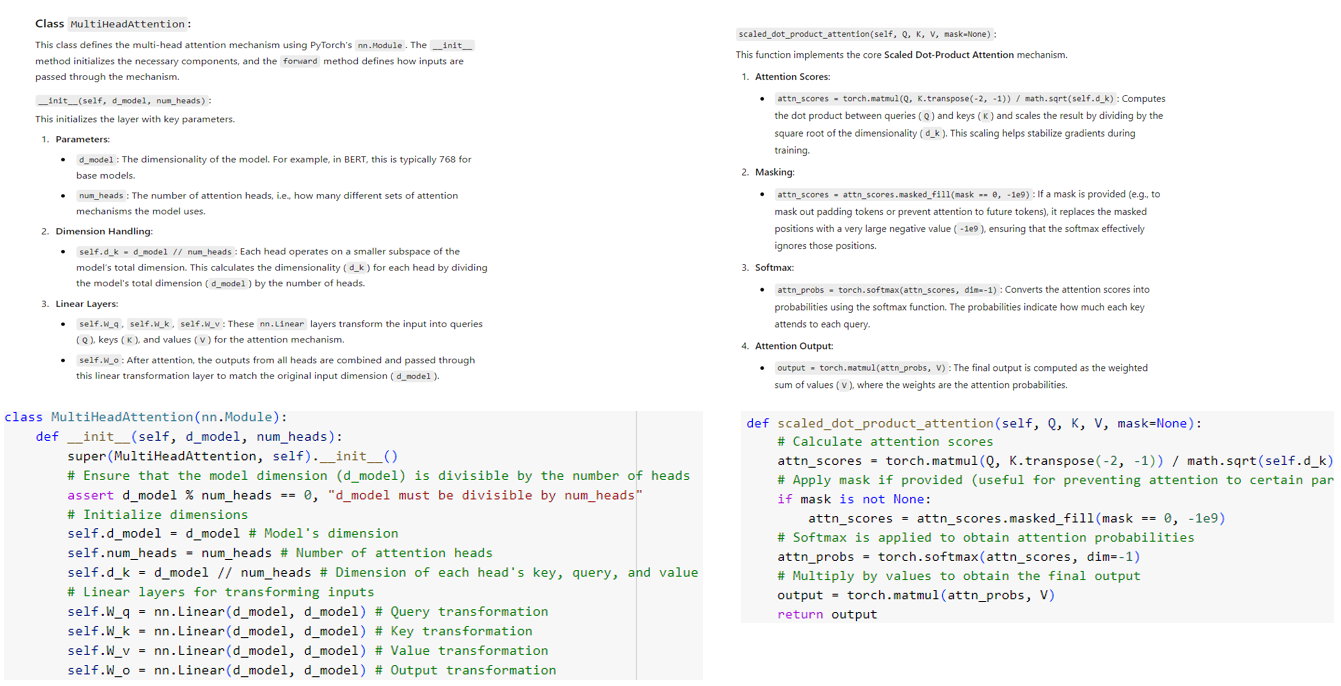

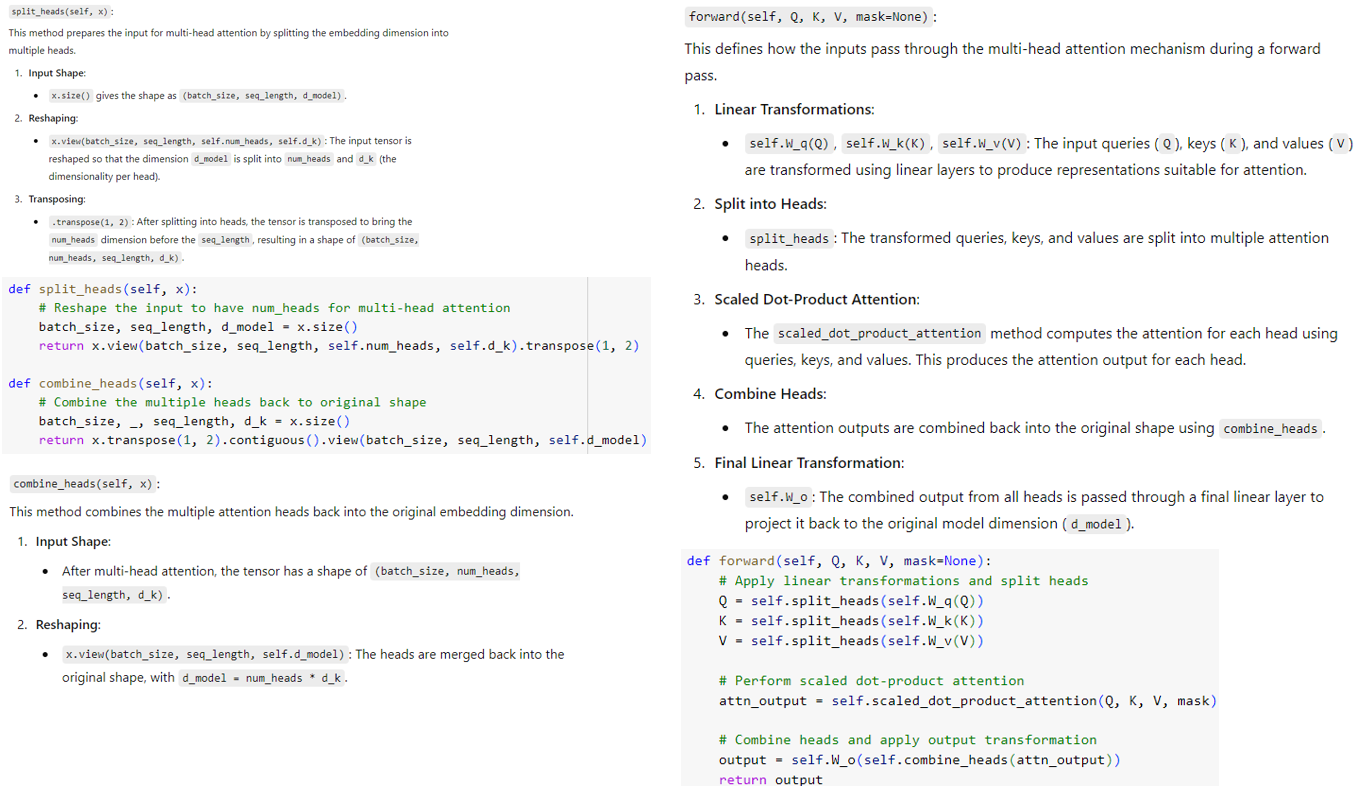

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

`The PositionWiseFeedForward class` is a component of the Transformer model that processes each position in the input sequence independently through a two-layer fully connected network (FCN). The architecture consists of the following:

- First Linear Layer (fc1): Projects the input from d_model dimensions to d_ff dimensions.
- ReLU Activation: Applies non-linearity using the ReLU function.
- Second Linear Layer (fc2): Projects the data back from d_ff to d_model dimensions, ensuring the input and output dimensions match.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

The PositionalEncoding class is used to add information about the relative positions of tokens in a sequence to their embeddings. Since the Transformer model does not inherently capture the order of tokens, this positional encoding helps inject sequence order information.

######Key Components:
- `Sine and Cosine Functions`: Alternating sine and cosine values are used to represent position information in a continuous way, allowing the model to generalize to varying sequence lengths.

- `Parameters`:
   - d_model: The dimensionality of the model (i.e., the embedding size).
   - max_seq_length: The maximum length of the sequence for which positional encodings are precomputed.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

`The EncoderLayer` class is a single layer of the Transformer encoder, consisting of two main sub-layers: multi-head self-attention and a feed-forward network, along with normalization and dropout.

##### Workflow:

- Self-Attention: The input x is passed through multi-head self-attention, allowing each token to attend to others. The result is added to the original input (x + attn_output), followed by layer normalization (norm1).

- Feed-Forward: The normalized output is passed through the position-wise feed-forward network. The result is added back to the input (x + ff_output), followed by another normalization (norm2).

- Dropout: Dropout is applied after both the attention and feed-forward outputs to reduce overfitting.

- Purpose: The EncoderLayer processes each token in the sequence by considering all tokens (via self-attention) and transforming the output through a feed-forward network, while maintaining normalization for stable training. Multiple such layers are stacked to form the full encoder.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

`The DecoderLayer class` is a single layer of the Transformer decoder. It processes the target sequence (output tokens) while attending to both the target sequence itself (self-attention) and the encoder output (cross-attention). The layer consists of three sub-layers: self-attention, cross-attention, and feed-forward, along with normalization and dropout.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers,
                 d_ff, src_seq_length, tgt_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.src_positional_encoding = PositionalEncoding(d_model, src_seq_length)
        self.tgt_positional_encoding = PositionalEncoding(d_model, tgt_seq_length)


        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to(device)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3).to(device)
        seq_length = tgt.size(1)
        # Create nopeak_mask on the same device as tgt
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length, device=device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.src_positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.tgt_positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

#####Workflow:

- Self-Attention: The target sequence x attends to itself, and the result is added to x with dropout and normalization.

- Cross-Attention: The output from the self-attention step attends to the encoder output (enc_output), aligning the source and target sequences.

- Feed-Forward: The result is passed through the feed-forward network, followed by another normalization.

- Purpose: The DecoderLayer helps the Transformer decoder understand both the target sequence and the encoded source sequence. It learns to translate, generate text, or perform other sequence-to-sequence tasks by attending to the correct context at each decoding step.

#####Transformer Model Overview

This code implements a Transformer model using PyTorch, designed for sequence-to-sequence tasks such as machine translation. It includes both the encoder and decoder components, with self-attention and feed-forward layers, along with positional encodings for better handling of sequences.


Key Components:

- Embedding Layers: encoder_embedding and decoder_embedding: Convert the input tokens (from source and target vocabularies) into dense vector representations of size d_model.

- Positional Encoding: src_positional_encoding and tgt_positional_encoding: Add positional information to the token embeddings since Transformers do not inherently capture sequence order.

- Encoder and Decoder Layers:
  - Encoder: Multiple layers (num_layers) of the EncoderLayer (self-attention + feed-forward).
  - Decoder: Multiple layers (num_layers) of the DecoderLayer (self-attention, cross-attention with encoder, and feed-forward).

- Fully Connected Layer: fc: A linear layer to map the decoder’s output to the target vocabulary size for generating predictions.

- Dropout: Regularization is applied using dropout to prevent overfitting.

- Mask Generation: The generate_mask function creates masks to prevent the model from attending to padding tokens or future tokens (in the case of the decoder).

#####Workflow:

- Masking: Masks are generated for both the source (src_mask) and target (tgt_mask) sequences, which prevent the model from attending to padding tokens or future tokens during decoding.

- Embedding and Positional Encoding: The source (src) and target (tgt) tokens are passed through their respective embedding layers and are combined with positional encodings.

- Encoder: The embedded source tokens are passed through multiple layers of the encoder, each of which applies self-attention followed by feed-forward operations, producing the encoded output (enc_output).

- Decoder: The embedded target tokens are passed through the decoder layers. The decoder performs both self-attention on the target and cross-attention with the encoder’s output.

- Final Output: The decoder's output is passed through a linear layer (fc) to map it to the target vocabulary size for prediction.

We initialize a Transformer model for a translation task, where the source language is English (en) and the target language is French (fr).

Key Details:
- en_vocab_size and fr_vocab_size: Vocabulary sizes of the English and French datasets.
- d_model = 100: The dimension of the model's embeddings (100-dimensional vectors).
- num_heads = 5: The number of attention heads used in the multi-head attention mechanism.
- num_layers = 4: The number of layers in both the encoder and decoder.
- d_ff = 50: The size of the feed-forward network within each layer.
- src_seq_length and tgt_seq_length: Sequence lengths for the source (English) and target (French) sequences.

In [ ]:
en_vocab_size = len(en_vocab)
fr_vocab_size = len(fr_vocab)

transformer = Transformer(en_vocab_size, fr_vocab_size, d_model = 100, num_heads = 5, num_layers= 4, d_ff = 50,
                          src_seq_length = en_seq_len, tgt_seq_length =fr_seq_len, dropout = 0.1).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

The function `generate_sentence` generates a target sentence using a Transformer model given an input source sentence. It tokenizes and encodes the input sentence based on the source vocabulary and initializes the target sentence with a beginning-of-sequence (BOS) token. The model then predicts the next token step by step until the end-of-sequence (EOS) token is produced or the specified maximum length is reached. After prediction, the target indices are converted back to tokens and joined to form the final generated sentence, excluding BOS and EOS tokens. This process occurs without updating model parameters.

In [ ]:
def generate_sentence(model, src_sentence, src_vocab, tgt_vocab, tgt_idx2word, max_length=10, device='cuda'):
    """
    Generate an output sentence given an input sentence using the Transformer model.

    Args:
        model (nn.Module): The Transformer model.
        src_sentence (str): The input sentence.
        src_vocab (dict): A dictionary mapping source tokens to indices.
        tgt_vocab (dict): A dictionary mapping target indices to tokens.
        max_len (int): The maximum length of the generated sentence.
        device (str): The device to perform the generation on.

    Returns:
        str: The generated sentence.
    """

    # Tokenize and encode the source sentence
    src_indices = [src_vocab.get(token) for token in src_sentence.split()]
    src_tensor = torch.LongTensor(src_indices).unsqueeze(0).to(device)  # Add batch dimension

    # Initialize the target tensor with the start token
    tgt_indices = [tgt_vocab['<bos>']]
    tgt_tensor = torch.LongTensor(tgt_indices).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            # Pass through the model
            output = model(src_tensor, tgt_tensor)

            # Get the last token's probabilities and choose the one with the highest probability
            next_token_logits = output[:, -1, :]
            next_token = torch.argmax(F.softmax(next_token_logits, dim=-1), dim=-1)
            # Append the predicted token to the target sequence
            tgt_tensor = torch.cat([tgt_tensor, next_token.unsqueeze(0)], dim=1)

            # If the end token is generated, stop the generation
            if next_token.item() == tgt_vocab['<eos>']:
                break

    # Convert the generated target indices back to tokens
    generated_sentence = [tgt_idx2word.get(idx) for idx in tgt_tensor.squeeze(0).tolist()]

    # Remove the start and end tokens
    generated_sentence = [token for token in generated_sentence[1:-1] if token]

    return ' '.join(generated_sentence)

The BaseTrainer class is designed to train a model, such as a Transformer, using a specified loss function (criterion), optimizer, and training data loader. `The fit method` trains the model over a given number of epochs, printing the progress and loss for each epoch. After each epoch, it generates a translation for a random source sentence and displays both the target and predicted sentences. `The train_one_epoch method` handles the training loop for one epoch by iterating over batches of training data, computing the loss, backpropagating gradients, and updating the model's parameters using the optimizer. The average loss for the epoch is then returned.

In [ ]:
class BaseTrainer:
    def __init__(self, model, criterion, optimizer, train_loader):
        self.model = model
        self.criterion = criterion  #the loss function
        self.optimizer = optimizer  #the optimizer
        self.train_loader = train_loader  #the train loader

    #the function to train the model in many epochs
    def fit(self, num_epochs):
        self.num_batches = len(self.train_loader)

        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')

            train_loss = self.train_one_epoch()
            print(
                f'{self.num_batches}/{self.num_batches} - loss: {train_loss:.4f} '
            )
            random_id = np.random.choice(len(sents_en))
            src_sentence = " ".join(sents_en[random_id])
            print(f'Source Sentence: {src_sentence}')
            print("Target Sentence: ", " ".join(sents_fr_out[random_id]))
            target_sentence = generate_sentence(transformer, src_sentence, en_vocab, fr_vocab, fr_idx2word, max_length =10, device=device)
            print(f'Translated Setence: {target_sentence}')

    #train in one epoch
    def train_one_epoch(self):
        self.model.train()
        running_loss  = 0.0

        for en_data, fr_in_data, fr_out_data  in train_loader:
          en_data, fr_in_data, fr_out_data = en_data.to(device), fr_in_data.to(device), fr_out_data.to(device)
          self.optimizer.zero_grad()
          output = transformer(en_data, fr_in_data)
          loss = criterion(output.contiguous().view(-1, fr_vocab_size), fr_out_data.contiguous().view(-1))
          loss.backward()
          self.optimizer.step()
          running_loss += loss.item()

        train_loss = running_loss / self.num_batches
        return train_loss

```
loss = criterion(output.contiguous().view(-1, fr_vocab_size), fr_out_data.contiguous().view(-1))

```

The loss is being calculated using the criterion, which is typically a loss function like CrossEntropyLoss. Here’s a detailed breakdown of what’s happening:

- Model Output Reshaping: `output.contiguous().view(-1, fr_vocab_size)`
 - output: This is the tensor of predictions produced by the model. Its shape is typically [batch_size, tgt_seq_length, fr_vocab_size], where batch_size is the number of sentences in a batch, tgt_seq_length is the length of the target sequences, fr_vocab_size is the size of the target vocabulary.
 - contiguous(): Ensures that the tensor’s memory is contiguous, which is often necessary before reshaping to avoid issues with non-contiguous memory. This operation makes sure that the tensor is stored in a single, contiguous block of memory.
 - view(-1, fr_vocab_size): Reshapes the tensor. -1 is used to infer the size of this dimension automatically based on the other dimensions. This results in a tensor with shape [batch_size * tgt_seq_length, fr_vocab_size], where the first dimension is the total number of target tokens across all sequences in the batch, the second dimension is the size of the vocabulary, representing the scores for each possible token in the vocabulary.

- Target Data Reshaping: `fr_out_data.contiguous().view(-1)`
  - fr_out_data: This is the tensor containing the true target labels. Its shape is typically [batch_size, tgt_seq_length], where batch_size is the number of sentences in a batch,  tgt_seq_length is the length of the target sequences.
  - contiguous(): Similar to the output tensor, this ensures that fr_out_data is in a contiguous block of memory.
  - view(-1): Flattens the tensor into a one-dimensional tensor of shape [batch_size * tgt_seq_length]. This represents the true labels for each token in the batch.

- Loss Calculation: The criterion, typically a loss function like torch.nn.CrossEntropyLoss, computes the loss between the model’s predictions and the true labels.

- Inputs to the criterion:
  - Predictions: The reshaped output tensor of shape [batch_size * tgt_seq_length, fr_vocab_size]. Each row contains the predicted scores (logits) for each vocabulary token.
 - Targets: The reshaped fr_out_data tensor of shape [batch_size * tgt_seq_length]. Each entry is the index of the true token in the vocabulary.

In [ ]:
trainer = BaseTrainer(transformer, criterion, optimizer, train_loader)
trainer.fit(50)

Epoch 1/50
32/32 - loss: 1.6924 
Source Sentence: i m ready !
Target Sentence:  je suis pret ! <eos>
Translated Setence: je suis en suis !
Epoch 2/50
32/32 - loss: 1.6767 
Source Sentence: goodbye !
Target Sentence:  adieu ! <eos>
Translated Setence: a la !
Epoch 3/50
32/32 - loss: 1.6544 
Source Sentence: of course !
Target Sentence:  mais ouais ! <eos>
Translated Setence: pour !
Epoch 4/50
32/32 - loss: 1.6373 
Source Sentence: take it .
Target Sentence:  prends le ! <eos>
Translated Setence: prends le !
Epoch 5/50
32/32 - loss: 1.6025 
Source Sentence: shut up !
Target Sentence:  la ferme ! <eos>
Translated Setence: toi !
Epoch 6/50
32/32 - loss: 1.5820 
Source Sentence: it stinks .
Target Sentence:  ca pue . <eos>
Translated Setence: ca a l ai .
Epoch 7/50
32/32 - loss: 1.5590 
Source Sentence: we lost .
Target Sentence:  nous fumes defaits . <eos>
Translated Setence: nous avons ete nous .
Epoch 8/50
32/32 - loss: 1.5317 
Source Sentence: i m timid .
Target Sentence:  je suis timid